### NASA IMAGE EXTRACTION

In [1]:
#Installation of nasapy api
!pip install nasapy

In [2]:
#Installation of gtts(Google To Text Speech)
!pip install gtts


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


In [4]:
# Run this cell first
!pip install nasapy python-dotenv gTTS


In [5]:
# Use getpass so the key doesn't display in the notebook
from getpass import getpass
import os

key = getpass("Enter your NASA_API_KEY (input hidden): ")
os.environ["NASA_API_KEY"] = key
print("API key set in environment.")


Enter your NASA_API_KEY (input hidden): ··········
API key set in environment.


In [6]:
import os
print("NASA_API_KEY present?:", "NASA_API_KEY" in os.environ)
print("Value (hidden):", ("SET" if os.environ.get("NASA_API_KEY") else "NOT SET"))
# uncomment to print actual key (not recommended)
# print(os.environ.get("NASA_API_KEY"))


NASA_API_KEY present?: True
Value (hidden): SET


Enter date (YYYY-MM-DD) between 1996-01-01 and today: 2006-10-04
APOD media_type: image
date: 2006-10-04

copyright: 
Michael J�ger  & 
Gerald Rhemann


title: Comet SWAN Brightens

explanation: A newly discovered comet has brightened enough to be visible this week with binoculars. The picturesque comet is already becoming a favored target for northern sky imagers.  Pictured above just last week, Comet SWAN showed a bright blue-green coma and an impressive tail. Comet C/2006 M4 (SWAN) was discovered in June in public images from the Solar Wind Anisotropies (SWAN) instrument of NASA and ESA's Sun-orbiting SOHO spacecraft. Comet SWAN, near magnitude six, will be visible with binoculars in the northeastern sky not far from the Big Dipper over the next few days before dawn.  The comet is expected to reach its peak brightness this week. Passing its closest to the Sun two days ago, Comet SWAN and will be at its closest to the Earth toward the end of this month.   Comet SWAN's unusual orbit a

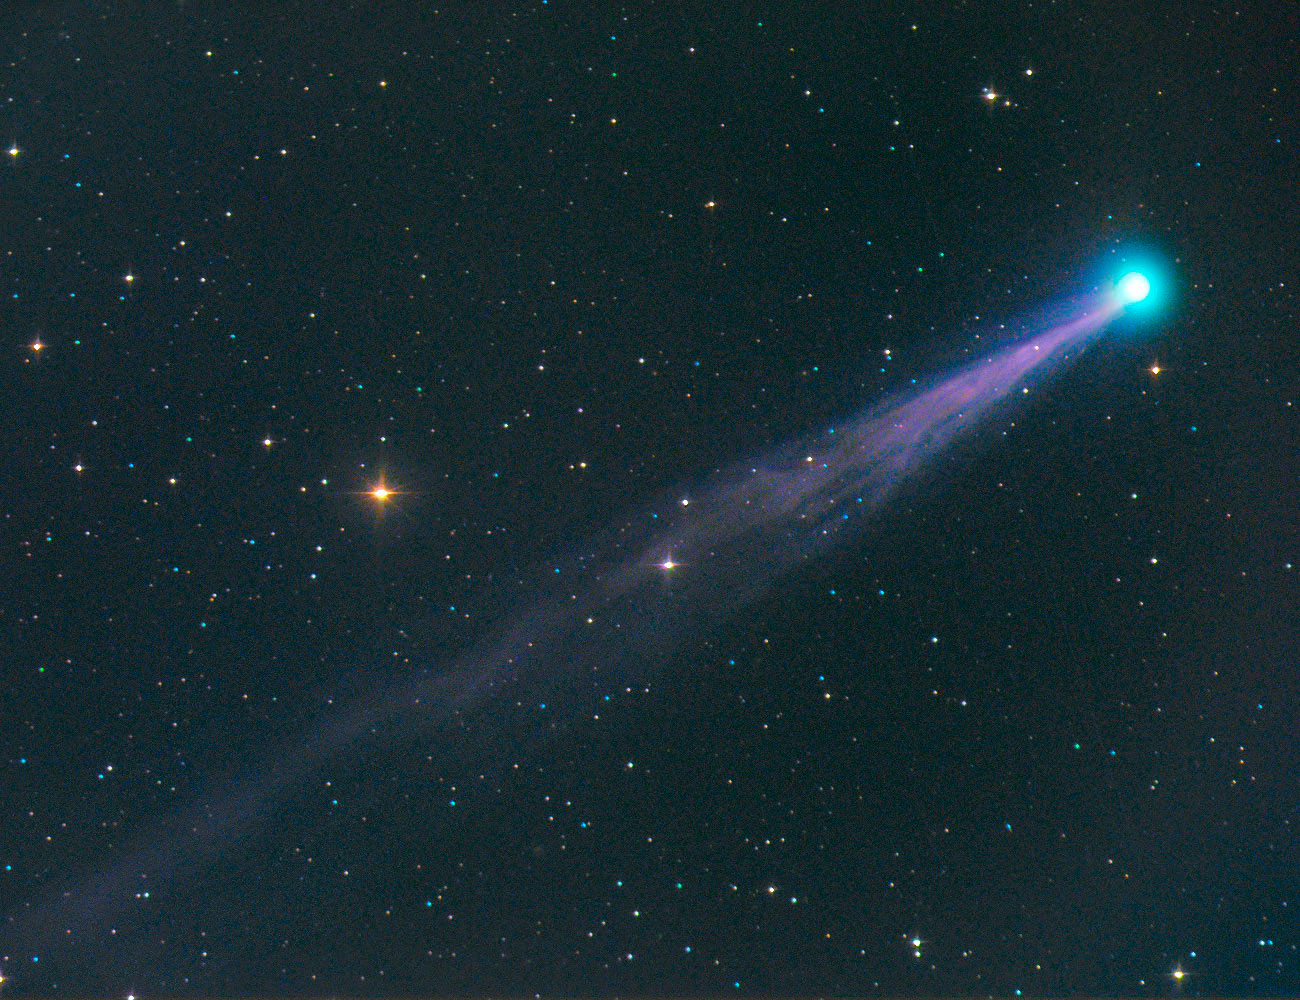

In [ ]:
# APOD downloader + TTS for Colab
import nasapy, os, urllib.request
from datetime import datetime
from IPython.display import Image, display, Audio, HTML
from gtts import gTTS
from dotenv import load_dotenv

# If you uploaded .env and used load_dotenv earlier, this ensures env vars are loaded:
load_dotenv()

api_key = os.getenv("NASA_API_KEY")
if not api_key:
    raise ValueError("NASA_API_KEY environment variable is not set. Use one of the methods in the instructions to set it.")

nasa = nasapy.Nasa(key=api_key)

def validate_date(date_str):
    try:
        datetime.strptime(date_str, '%Y-%m-%d')
        date = datetime.strptime(date_str, '%Y-%m-%d').date()
        today = datetime.now().date()
        return (date >= datetime.strptime('1996-01-01','%Y-%m-%d').date() and date <= today)
    except ValueError:
        return False

# ask user for date (you can modify to hard-code)
while True:
    user_date = input("Enter date (YYYY-MM-DD) between 1996-01-01 and today: ").strip()
    if validate_date(user_date):
        break
    print("Invalid date or out of range. Try again.")

apod = nasa.picture_of_the_day(date=user_date, hd=True)
print("APOD media_type:", apod.get("media_type"))

# directory in Colab
image_dir = "/content/Astro_Images"
os.makedirs(image_dir, exist_ok=True)

if apod.get("media_type") == "image":
    hdurl = apod.get("hdurl") or apod.get("url")
    title_safe = apod.get("title","apod").replace(" ","_").replace(":","_")
    filename = f"{user_date}_{title_safe}.jpg"
    filepath = os.path.join(image_dir, filename)
    urllib.request.urlretrieve(hdurl, filepath)
    # display metadata
    for k in ("date","copyright","title","explanation","hdurl","url"):
        if k in apod:
            print(f"{k}: {apod[k]}\n")
    # show image
    display(Image(filepath))
    # TTS choice
    choice = input("Type 'a' to generate/play audio explanation, anything else to skip: ").strip().lower()
    if choice == "a":
        text = apod.get("explanation","No explanation available.")
        tts = gTTS(text=text, lang="en", slow=False)
        audio_title = f"{user_date}_{title_safe}.mp3"
        audio_path = os.path.join(image_dir, audio_title)
        tts.save(audio_path)
        print("Saved audio to:", audio_path)
        display(Audio(audio_path, autoplay=True))
else:
    # if video (YouTube/embed), try to show embed or URL
    if apod.get("media_type") == "video":
        video_url = apod.get("url")
        print("Video URL:", video_url)
        # Try embedding (works for many YouTube links)
        display(HTML(f'<iframe width="800" height="450" src="{video_url}" frameborder="0" allowfullscreen></iframe>'))
    else:
        print("Media not supported:", apod.get("media_type"))
